Let us import all the libraries we need. 


In [272]:
import numpy as np
import math
from PIL import Image
import random
import gudhi as gd
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image
from sklearn.neighbors.kde import KernelDensity
import matplotlib.pyplot as plt
import copy

In the first experiment we will create a 2Nx2N grid that covers a rectangle [-2,2]x[-2,2].
On that grid we will approximate the function equal to distance of a centre of a grid to the unit circle x^2+y^2 = 1.

In [273]:
N = 100
array = np.zeros((2*N+1,2*N+1))
xExtrem = 2;
yExtrem = 2;
bitmap = []
dx = xExtrem/N
dy = yExtrem/N
for i in range(-N,N):
  for j in range(-N,N):
    x = i*dx
    y = j*dy
    distance=math.fabs( math.sqrt(x*x+y*y) - 1 )
    array[i+N][j+N] = distance
    bitmap.append(distance)

Let us display the grayscale image that we have created:

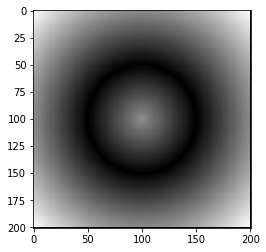

In [274]:
#Here we will display our creation:
plt.imshow(array,cmap='gray',vmin=np.amin(array),vmax=np.amax(array))
plt.show()

Now, let us compute the persistent homology of the obtained cubical complex:

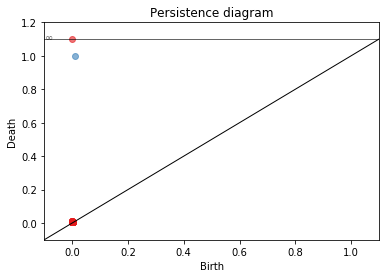

In [275]:
#Given the input data we can build a Gudhi bitmap cubical complex:
bcc=gd.CubicalComplex(top_dimensional_cells=bitmap,dimensions=[2*N,2*N])
ph1 = bcc.persistence()
#print(ph1)
pers_diag = gd.plot_persistence_diagram( ph1 )

Now, to see how stability theorem works in practice, let us perturb the bitmap we obtained. 


In [282]:
amount_of_perturbation = 0.2
values = amount_of_perturbation*np.random.rand( len(bitmap) )
perturbed_bitmap = bitmap+values
#print(values)

And given the perturbed bitmap, let us compute its persistent homology.

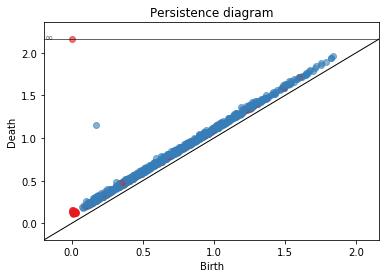

In [283]:
bcc2=gd.CubicalComplex(top_dimensional_cells=perturbed_bitmap,dimensions=[2*N,2*N])
ph2 = bcc2.persistence()
#print(ph2)
pers_diag_2 = gd.plot_persistence_diagram( ph2 )

We see that the two obtained diagrams are close. In fact, we can compute the Bottleneck distance to make sure that they are at most 0.2 appart. To do this, let us first extract the finite persistence pairs in dimension 0 and 1:


In [284]:
ph1_finite_intervals_in_dim_0 = []
ph1_finite_intervals_in_dim_1 = []
for i in range(0,len(ph1)):
    if ( ph1[i][0] == 0 ) & ( ph1[i][1][1] != float('Inf') ):
        ph1_finite_intervals_in_dim_0.append( ph1[i][1] )
    if ( ph1[i][0] == 1 ) & ( ph1[i][1][1] != float('Inf') ):
        ph1_finite_intervals_in_dim_1.append( ph1[i][1] )

In [285]:
ph2_finite_intervals_in_dim_0 = []
ph2_finite_intervals_in_dim_1 = []
for i in range(0,len(ph2)):
    if ( ph2[i][0] == 0 ) & ( ph2[i][1][1] != float('Inf') ):
        ph2_finite_intervals_in_dim_0.append( ph2[i][1] )
    if ( ph2[i][0] == 1 ) & ( ph2[i][1][1] != float('Inf') ):
        ph2_finite_intervals_in_dim_1.append( ph2[i][1] )

Now we can compute the bottleneck distance:

In [286]:
dist_dim_0 = gd.bottleneck_distance(ph1_finite_intervals_in_dim_0,ph2_finite_intervals_in_dim_0)
dist_dim_1 = gd.bottleneck_distance(ph1_finite_intervals_in_dim_1,ph2_finite_intervals_in_dim_1)
print( 'Bottleneck distance in dimension 0 is ',dist_dim_0,' and in dimension 1 is ',dist_dim_1, ' while the amount of perturbation of data is', amount_of_perturbation)

Bottleneck distance in dimension 0 is  0.07746637176336901  and in dimension 1 is  0.1585226294544066  while the amount of perturbation of data is 0.2


OK, let us try some other use of cubical complexes! Let us sample points from a unit circle. 

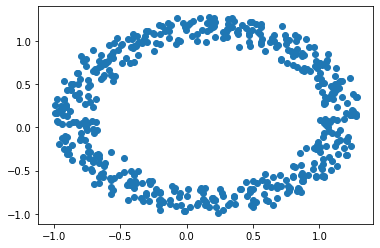

In [287]:
import matplotlib.pyplot as plt
number_of_points = 500
amplitude_of_noise = 0.3
arg = np.linspace(0,10*math.pi,number_of_points)
x = np.sin(arg) + amplitude_of_noise*np.random.rand( number_of_points )
y = np.cos(arg) + amplitude_of_noise*np.random.rand( number_of_points )
plt.scatter(x,y)
plt.show()

Now let us create a kernel density estimator based on this colleciton of points. 

In [288]:
points = np.column_stack((x, y))
#print( points )
xval = np.arange(-2,2,0.05)
yval = np.arange(-2,2,0.05)
kde = KernelDensity(kernel='gaussian',bandwidth=0.3).fit(points)
#print(kde)
positions = np.array([[u,v] for u in xval for v in yval])
#print(positions)
scores = -np.exp(kde.score_samples(X=positions))

Let us plot the obtained KDE.

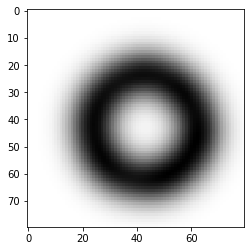

In [289]:
img = np.reshape(scores, (len(xval), len(yval)))

plt.imshow(img,cmap='gray',vmin=np.amin(img),vmax=np.amax(img))
plt.show()

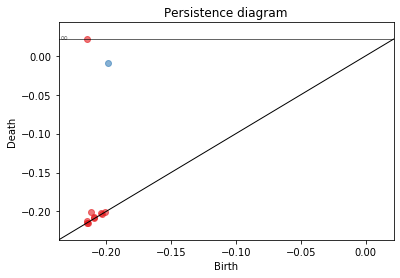

In [291]:
cc_density_crater = gd.CubicalComplex( dimensions=[len(xval),len(yval)] , top_dimensional_cells=scores )
pers_density_crater = cc_density_crater.persistence()
this_diag = gd.plot_persistence_diagram(pers_density_crater)

Persistent homology is stable when we add a random BOUNDED noise. We see it in the persistence stability theorem, we will see it later in this notebook. But how about uniform noise generated from [-1,1]x[-1,1], like the one below:


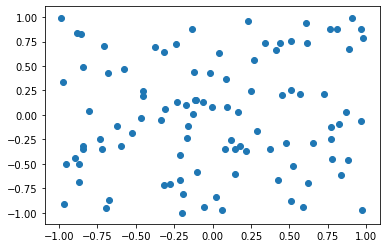

In [292]:
nr_of_random_pts = 100
random_points_from_square = 2*np.random.rand( nr_of_random_pts , 2 )-1
plt.scatter(random_points_from_square[:,0],random_points_from_square[:,1])
plt.show()

Let us add this point cloud to the unit circle point cloud:

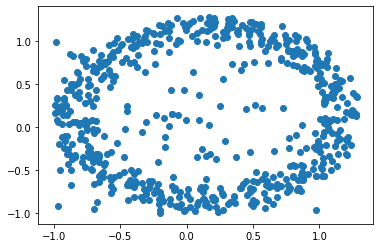

In [293]:
uniform_noise_plus_circle = np.concatenate( (points , random_points_from_square) , axis = 0 )
plt.scatter(uniform_noise_plus_circle[:,0],uniform_noise_plus_circle[:,1])
plt.show()

Now let us create a kernel density estimator of this point cloud and compute its persistent homology:

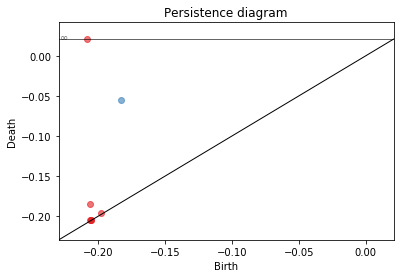

In [294]:
xval = np.arange(-2,2,0.05)
yval = np.arange(-2,2,0.05)
kde_un_p_c = KernelDensity(kernel='gaussian',bandwidth=0.3).fit(uniform_noise_plus_circle)
positions = np.array([[u,v] for u in xval for v in yval])
scores_points_plus_noise = -np.exp(kde_un_p_c.score_samples(X=positions))

cc_points_plus_noise = gd.CubicalComplex( dimensions=[len(xval),len(yval)] , top_dimensional_cells=scores_points_plus_noise )
pers_points_plus_noise = cc_points_plus_noise.persistence()
diag_points_plus_noise = gd.plot_persistence_diagram( pers_points_plus_noise )

Let us now play with the random collection of points and observe how the persistent homology of the kernel density is changing with respect to the number of points.

In [295]:
number_of_points = 10;
number_of_cubes_in_each_direction = 50;

random_points_from_unit_cube = np.random.rand( number_of_points , 3 )
xval = np.arange(0,1,1/number_of_cubes_in_each_direction)
yval = np.arange(0,1,1/number_of_cubes_in_each_direction)
zval = np.arange(0,1,1/number_of_cubes_in_each_direction)

kde = KernelDensity(kernel='gaussian',bandwidth=0.1).fit(random_points_from_unit_cube)
positions_kde = np.array([[u,v,z] for u in xval for v in yval for z in zval])
scores_kde = -np.exp(kde.score_samples(X=positions_kde))

Now let us compute the persistent homology of the obrained random distribution

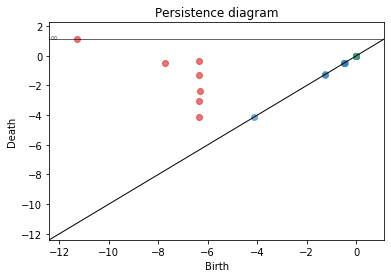

In [296]:
kde_cubical_complex = gd.CubicalComplex( dimensions=[len(xval),len(yval),len(zval)] , top_dimensional_cells=scores_kde )
kde_persistence = kde_cubical_complex.persistence()
kde_diagram = gd.plot_persistence_diagram( kde_persistence )

Let us play now with simplicial complexes obtained from point clouds. As a working example let us generate a noisy figure 8 point cloud in R^2

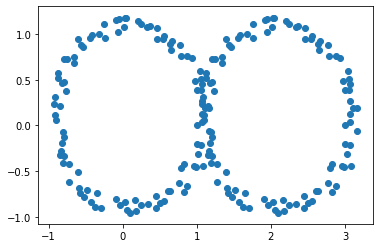

In [297]:
number_of_points = 100
amplitude_of_noise = 0.2
arg = np.linspace(0,2*math.pi,number_of_points)
x = np.sin(arg) + amplitude_of_noise*np.random.rand( number_of_points )
y = np.cos(arg) + amplitude_of_noise*np.random.rand( number_of_points )
xp = 2+x
yp = y
x = np.concatenate([x,xp])
y = np.concatenate([y,yp])
plt.scatter(x,y)
plt.show()
points = np.column_stack((x, y))

Let us compute Rips complex for this point cloud and subsequently its persistence. Let us measure the time it take!

In [298]:
%%time
rips_cmplx = gd.RipsComplex(points = points , max_edge_length = 2)
st = rips_cmplx.create_simplex_tree(max_dimension=2)
diag = st.persistence(homology_coeff_field=2, min_persistence=0)

Wall time: 277 ms


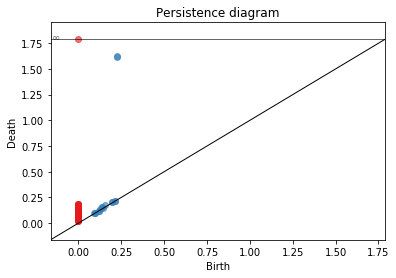

In [299]:
diag = gd.plot_persistence_diagram(diag)

Now, let us do the same computations, this time using Alpha complex:

In [300]:
%%time
alpha_cmplx = gd.AlphaComplex(points = points)
st = alpha_cmplx.create_simplex_tree()
alpha_pers = st.persistence(homology_coeff_field=2, min_persistence=0)

Wall time: 19.9 ms


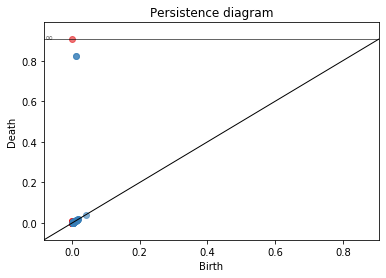

In [301]:
diag = gd.plot_persistence_diagram(alpha_pers)

Point cloud data offers also a good opportunity to examine geometrical stability of persistence. For this purpose let us take the points we have and let us add to them a little bit of noise:

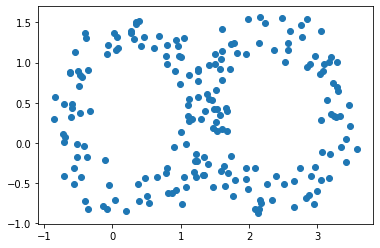

In [302]:
amplitude_of_noise = 0.5
perturbed_points = copy.deepcopy(points)
#plt.scatter( points[:,0] , points[:,1] )
perturbed_points[:,0] = perturbed_points[:,0] + amplitude_of_noise*np.random.rand( len(perturbed_points[:,0]) )
perturbed_points[:,1] = perturbed_points[:,1] + amplitude_of_noise*np.random.rand( len(perturbed_points[:,1]) )
plt.scatter( perturbed_points[:,0] , perturbed_points[:,1] )

Now, let us compute persistent homology of the initial and the perturbed points. 

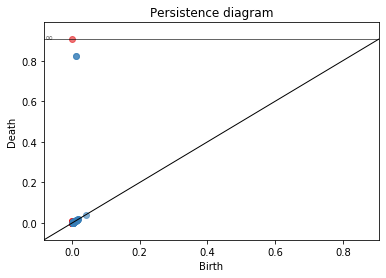

In [303]:
alpha_cmplx_pts = gd.AlphaComplex(points)
st_pts = alpha_cmplx_pts.create_simplex_tree()
alpha_pers_pts = st_pts.persistence(homology_coeff_field=2, min_persistence=0)
diag_pers_pts = gd.plot_persistence_diagram(alpha_pers_pts)

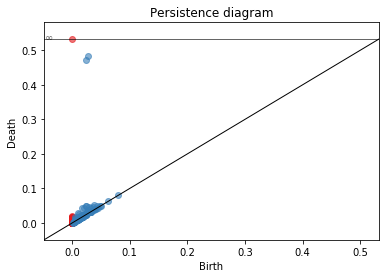

In [304]:
alpha_cmplx_perturbed_pts = gd.AlphaComplex(perturbed_points)
st_perturbed_pts = alpha_cmplx_perturbed_pts.create_simplex_tree()
alpha_pers_perturbed_pts = st_perturbed_pts.persistence(homology_coeff_field=2, min_persistence=0)
diag_pers_perturbed_pts = gd.plot_persistence_diagram(alpha_pers_perturbed_pts)

Now let us extract 1 dimensional intervals and compute their bottleneck distance. 

In [309]:
ph1_finite_intervals_in_dim_1_not_petrurbed = []
for i in range(0,len(alpha_pers_pts)):
    if ( alpha_pers_pts[i][0] == 1 ):
        ph1_finite_intervals_in_dim_1_not_petrurbed.append( alpha_pers_pts[i][1] )

ph1_finite_intervals_in_dim_1_petrurbed = []
for i in range(0,len(alpha_pers_perturbed_pts)):
    if ( alpha_pers_perturbed_pts[i][0] == 1 ):
        ph1_finite_intervals_in_dim_1_petrurbed.append( alpha_pers_perturbed_pts[i][1] )
        
dist_dim_1 = gd.bottleneck_distance(ph1_finite_intervals_in_dim_1_not_petrurbed,ph1_finite_intervals_in_dim_1_petrurbed)
print( 'Bottleneck distance in dimension 1 is ',dist_dim_1,' while the amount of perturnation is ',amplitude_of_noise)

Bottleneck distance in dimension 1 is  0.35143761021533804  while the amount of perturnation is  0.5
